In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [2]:
%matplotlib inline
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
import requests
import json
import time
import os
from pprint import pprint
import datetime

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns
from zones import get_zones_for_id, build_week_summary

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [4]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Using access token: caceb0c4eff5fe82c0154f739b7d870a94461d81
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


In [5]:
# establish an empty strava_df and strava_zone_df for building-up from scratch 
# used when no previous data is do be loaded e.g. different user, different year
columns =['id', 'name', 'date', 'sport', 'distance', 'time', 'speed', 'elev_gain',
       'avg_HR', 'max_HR', 'suffer_score', 'time-minutes', 'average_speed',
       'start_date']
strava_df = pd.DataFrame(columns=columns)

columns = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start',
       'weekly_intense', 'weekly_moderate', 'weekly_suffer_score']
strava_zone_df = pd.DataFrame(columns=columns)

In [ ]:
# select year for pickle file 
# Reload dfs and confirm lengths
strava_df = pd.read_pickle("data/strava_data_2024.pkl")
strava_zone_df = pd.read_pickle("data/strava_zone_data_2024.pkl")

print(len(strava_df))
print(len(strava_zone_df))

In [6]:
# last entry date
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score


### Recent activities only!

In [7]:
# select date to start new activities data collection
startdate_string = '2024-01-28'
enddate_string = '2024-02-10'

# change date to unix integer format
start_date = int(time.mktime(time.strptime(startdate_string, '%Y-%m-%d')))
end_date = int(time.mktime(time.strptime(enddate_string, '%Y-%m-%d')))

# strava url
url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []

stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        # breaks out of while loop
        break
        
    for activity in data:
        # change date to unix integer format
        activity_date = int(datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        # print(activity['start_date'])
        print(activity_date)
        if activity_date >= end_date:
            stop_fetching = True
            # breaks out of for loop only
            break 
        # set number of activites (strava maximum is 100/15 minutes)
        if len(activities) >= 6:
            stop_fetching = True
            # breaks out of for loop only
            break
        activities.append(activity)
    params["page"] += 1


# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

# This step does the comparison between recent_df and strava_df
# strava_df holds previously saved data

if strava_df.empty:
    new_activities_df = recent_df.copy()
else:
    new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
new_activities_df

1706454715
1706463687
1706545442
1706629132
1706717097
1706802655
1706887305


,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
5,10674790188,"Calpe D8 Pego, Olivia loop",116888.0,18630,1314.0,Ride,6.3,109.0,148.0,181.0,2024-02-01T08:50:55Z
4,10667801807,Calpe D7 ‘Serra D'Aiyana’ loop,111059.0,19223,2051.0,Ride,5.8,108.4,136.0,195.0,2024-01-31T09:04:57Z
3,10659770769,Calpe D6 Coll de Rate via Altea,65098.0,10640,1206.0,Ride,6.1,107.5,130.0,104.0,2024-01-30T08:38:52Z
2,10653080337,Calpe D5 La Musette,54894.7,9308,787.0,Ride,5.9,103.8,139.0,74.0,2024-01-29T09:24:02Z
1,10647521880,Calpe D4 Puerto de Bernia Balcons loop,55864.3,10355,1006.0,Ride,5.4,99.8,158.0,66.0,2024-01-28T10:41:27Z
0,10645136880,Calpe Walk,7161.0,4993,56.0,Walk,1.4,158.3,215.0,347.0,2024-01-28T08:11:55Z


In [8]:
def process_new_data (new_activities_df, strava_df):
    if new_activities_df.empty:
        print("No new activities to process.")
        return None

    # proceed with combining or processing
    new_activities_df = cleanup (new_activities_df)
    new_activities_df['converted_speed'] = new_activities_df.apply(convert_speed, axis=1)
    new_activities_df = order_columns(new_activities_df)

    strava_df = pd.concat ([new_activities_df, strava_df])
    #strava_df.head()
    return strava_df

strava_df = process_new_data(new_activities_df, strava_df)

In [9]:
strava_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
5,10674790188,"Calpe D8 Pego, Olivia loop",2024-02-01,Ride,72.6,5:10,14.0,4311.0,109.0,148.0,181.0,310.5,6.3,2024-02-01 08:50:55+00:00


In [10]:
new_activities_df.id

5    10674790188
4    10667801807
3    10659770769
2    10653080337
1    10647521880
0    10645136880
Name: id, dtype: int64

In [11]:
# Recent zone data
# Create a new_zone dataframe for recent activities
cols = ['id', 'name', 'date', 'suffer_score','start_date']
new_data = strava_df.loc[:,cols]
new_zone_df = pd.DataFrame(new_data, columns=cols)

mask = new_zone_df['id'].isin(new_activities_df['id'])
new_zone_df = new_zone_df[mask]

In [12]:
zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
zone.index = new_zone_df['id']

# Add in summary zones: moderate and intense
zone['moderate'] = zone[['Zone1', 'Zone2']].sum(axis=1)
zone['intense'] = zone[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)
zone

Fetching zones for activity: 10674790188
Fetching zones for activity: 10667801807
Fetching zones for activity: 10659770769
Fetching zones for activity: 10653080337
Fetching zones for activity: 10647521880
Fetching zones for activity: 10645136880


,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
id,,,,,,,
10674790188,39.8,225.3,26.5,1.9e+01,0.0,265.1,45.4
10667801807,52.8,204.9,62.7,0.0e+00,0.0,257.7,62.7
10659770769,37.2,111.8,28.4,0.0e+00,0.0,148.9,28.4
10653080337,44.1,84.8,24.3,1.9e+00,0.0,128.9,26.2
10647521880,55.7,105.6,11.1,8.3e-02,0.2,161.2,11.3
10645136880,2.3,6.9,2.5,3.7e+00,67.9,9.2,74.0


In [13]:
new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)

In [14]:
# Get the Sunday start of the week for each date (time set to midnight)
new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

#new_zone_df.columns are now matched with strava_zone_df
new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)

In [15]:
new_zone_df.head()

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
5,10674790188,"Calpe D8 Pego, Olivia loop",2024-02-01,181.0,2024-02-01 08:50:55+00:00,39.8,225.3,26.5,1.9e+01,0.0,265.1,45.4,2024-01-29,NaN,NaN,NaN
4,10667801807,Calpe D7 ‘Serra D'Aiyana’ loop,2024-01-31,195.0,2024-01-31 09:04:57+00:00,52.8,204.9,62.7,0.0e+00,0.0,257.7,62.7,2024-01-29,NaN,NaN,NaN
3,10659770769,Calpe D6 Coll de Rate via Altea,2024-01-30,104.0,2024-01-30 08:38:52+00:00,37.2,111.8,28.4,0.0e+00,0.0,148.9,28.4,2024-01-29,NaN,NaN,NaN
2,10653080337,Calpe D5 La Musette,2024-01-29,74.0,2024-01-29 09:24:02+00:00,44.1,84.8,24.3,1.9e+00,0.0,128.9,26.2,2024-01-29,NaN,NaN,NaN
1,10647521880,Calpe D4 Puerto de Bernia Balcons loop,2024-01-28,66.0,2024-01-28 10:41:27+00:00,55.7,105.6,11.1,8.3e-02,0.2,161.2,11.3,2024-01-22,NaN,NaN,NaN


In [16]:
# This drops all weekly_ cols since they are all recalculated later
only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start']
new_zone_df = new_zone_df[only_cols]
#new_zone_df.head()

# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = new_zone_df.sort_values(['week_start', 'start_date'])

In [17]:
# Calculate cumulative sum within each week for weekly_ cols
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
# Add start_date column for reference
cumulative_sums['start_date'] = temp['start_date']
cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
cumulative_sums.head(3)
strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')

### Plotting Section

In [18]:
strava_zone_df.head()

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,10674790188,"Calpe D8 Pego, Olivia loop",2024-02-01,181.0,2024-02-01 08:50:55+00:00,39.8,225.3,26.5,1.9e+01,0.0,265.1,45.4,2024-01-29,162.7,800.7,554.0
1,10667801807,Calpe D7 ‘Serra D'Aiyana’ loop,2024-01-31,195.0,2024-01-31 09:04:57+00:00,52.8,204.9,62.7,0.0e+00,0.0,257.7,62.7,2024-01-29,117.2,535.6,373.0
2,10659770769,Calpe D6 Coll de Rate via Altea,2024-01-30,104.0,2024-01-30 08:38:52+00:00,37.2,111.8,28.4,0.0e+00,0.0,148.9,28.4,2024-01-29,54.6,277.9,178.0
3,10653080337,Calpe D5 La Musette,2024-01-29,74.0,2024-01-29 09:24:02+00:00,44.1,84.8,24.3,1.9e+00,0.0,128.9,26.2,2024-01-29,26.2,128.9,74.0
4,10647521880,Calpe D4 Puerto de Bernia Balcons loop,2024-01-28,66.0,2024-01-28 10:41:27+00:00,55.7,105.6,11.1,8.3e-02,0.2,161.2,11.3,2024-01-22,85.3,170.5,413.0


In [19]:
week_summary = build_week_summary(strava_zone_df)
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
1,2024-01-29,162.7,800.7,554.0,Jan 29
0,2024-01-22,85.3,170.5,413.0,Jan 22


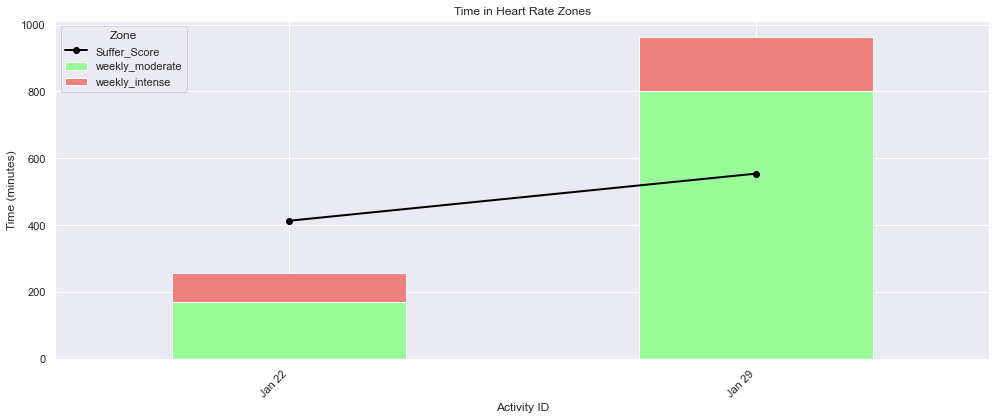

In [20]:
import matplotlib.pyplot as plt

ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="Suffer_Score"  
)

plt.title("Time in Heart Rate Zones")
plt.xlabel("Activity ID")
plt.ylabel("Time (minutes)")
plt.legend(title="Zone")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Melt the DataFrame to long format and plot
long_df = pd.melt(
    week_summary,
    id_vars="week",
    value_vars=["weekly_intense", "weekly_moderate"],
    var_name="zone",
    value_name="minutes"
)

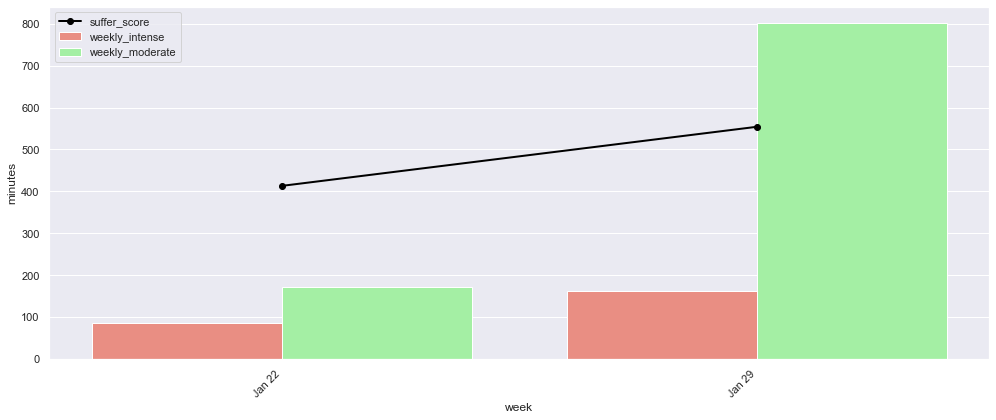

In [22]:
# Add a line plot on top 
plt.figure(figsize=(14, 6))
# Add line plot with a label
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"weekly_intense": "salmon", "weekly_moderate": "palegreen"}
)
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="suffer_score"  
)
# Create the legend manually from all handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Optional: improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

In [23]:
strava_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
5,10674790188,"Calpe D8 Pego, Olivia loop",2024-02-01,Ride,72.6,5:10,14.0,4311.0,109.0,148.0,181.0,310.5,6.3,2024-02-01 08:50:55+00:00


In [24]:
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,10674790188,"Calpe D8 Pego, Olivia loop",2024-02-01,181.0,2024-02-01 08:50:55+00:00,39.8,225.3,26.5,18.9,0.0,265.1,45.4,2024-01-29,162.7,800.7,554.0


In [25]:
print(len(strava_df))
print(len(strava_zone_df))

6
6


In [ ]:
# Save both
strava_df.to_pickle("data/strava_data_2024.pkl")
strava_zone_df.to_pickle("data/strava_zone_data_2024.pkl")

print("All data saved.")